# Imports

In [7]:
import pandas as pd
from pathlib import Path
import os
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
import seaborn as sns  # Opcional, para estilização
from sklearn.metrics import explained_variance_score

# Obtenção dos dados

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Implementação

In [35]:
def train_model(X_scaled, Y_scaled):
    max_lv = 10
    lvs = []
    k=1
    loo = LeaveOneOut()
    
    calibration = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'neg_root_mean_squared_error_cal', 'explained_variance_cal', 'correlation_cal', 'rpearson_cal', 'secv_cal'])
    validation = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'secv_cv'])
    
    Y_values = pd.DataFrame(index=range(len(Y_scaled)))
    Y_values['Referencia'] = Y_scaled.flatten()  # Valores reais de Y
        
    for lv in range(1, max_lv + 1):
        pls_model = PLSRegression(n_components=lv, max_iter=100)

        # Calibração do modelo
        pls_model.fit(X_scaled, Y_scaled)
        predictions_train = pls_model.predict(X_scaled)

        # Calcula as métricas para a fase de calibração
        calibration.loc[lv, 'r2_cal'] = r2_score(Y_scaled, predictions_train)
        calibration.loc[lv, 'neg_root_mean_squared_error_cal'] = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'explained_variance_cal'] = explained_variance_score(Y_scaled, predictions_train)

        # Garantir que Y_scaled e predictions_train sejam arrays bidimensionais
        if Y_scaled.ndim == 1:
            Y_scaled = Y_scaled.reshape(-1, 1)
        if predictions_train.ndim == 1:
            predictions_train = predictions_train.reshape(-1, 1)

        correlation_cal = np.corrcoef(Y_scaled[:, 0], predictions_train[:, 0])[0, 1]  # Correlação
        calibration.loc[lv, 'correlation_cal'] = correlation_cal

        # Calcular rpearson para calibração
        rpearson_cal = correlation_cal ** 2
        calibration.loc[lv, 'rpearson_cal'] = rpearson_cal

        # Calcular o viés para calibração
        bias_cal = np.mean(predictions_train - Y_scaled)
        calibration.loc[lv, 'bias_cal'] = bias_cal

        # Calcular SE (Standard Error) para calibração
        sec_cal = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'sec_cal'] = sec_cal
        
        # Adicionar as previsões de calibração ao DataFrame Y_values
        Y_values[f'Calibracao_LV{lv}'] = predictions_train.flatten()

        # Validação cruzada (Leave-One-Out)
        predictions_cv = cross_val_predict(pls_model, X_scaled, Y_scaled, cv=loo)

        # Calcula as métricas para a validação cruzada
        validation.loc[lv, 'r2_cv'] = r2_score(Y_scaled, predictions_cv)
        validation.loc[lv, 'neg_root_mean_squared_error_cv'] = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'explained_variance_cv'] = explained_variance_score(Y_scaled, predictions_cv)

        # Garantir que predictions_cv seja array bidimensional
        if predictions_cv.ndim == 1:
            predictions_cv = predictions_cv.reshape(-1, 1)

        correlation_cv = np.corrcoef(Y_scaled[:, 0], predictions_cv[:, 0])[0, 1]  # Correlação
        validation.loc[lv, 'correlation_cv'] = correlation_cv

        # Calcular rpearson para validação cruzada
        rpearson_cv = correlation_cv ** 2
        validation.loc[lv, 'rpearson_cv'] = rpearson_cv

        # Calcular o viés para validação cruzada
        bias_cv = np.mean(predictions_cv - Y_scaled)
        validation.loc[lv, 'bias_cv'] = bias_cv

        # Calcular SECV (Standard Error of Cross Validation)
        secv_cv = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'secv_cv'] = secv_cv
        
        # Adicionar as previsões de validação ao DataFrame Y_values
        Y_values[f'Validacao_LV{lv}'] = predictions_cv.flatten()
    
               
    #print(results)
    
    for j in range(1, max_lv):
        if j + 1 <= max_lv:
            rmsecv_j = validation.loc[j + 1, 'rpearson_cv']
            rmsecv_j_plus_1 = validation.loc[j, 'rpearson_cv']
            aux = rmsecv_j / rmsecv_j_plus_1
            
            if aux > 1 and ((aux - 1) * 100 >= 2):
                lvs.append(j + 1)
                k += 1
    
    if len(lvs) == 0:
        lvs.append(1)
    
    lv_num = lvs[-1]
    
    if len(lvs) > 1:
        pls_model = PLSRegression(n_components=lvs[-2])
        pls_model.fit(X_scaled, Y_scaled)

        for w in range(k - 2):
            if pls_model.coef_.shape[1] > 3:
                if lvs[w + 1] < pls_model.coef_.shape[0] and pls_model.coef_[lvs[w + 1], 3] < 1:
                    lv_num = lvs[w]
                    break

        model = pls_model.fit(X_scaled, Y_scaled)
    else:
        pls_model = PLSRegression(n_components=lvs[0])
        model = pls_model.fit(X_scaled, Y_scaled)

    
    return calibration, validation, lv_num, model, Y_values

def center_data(X, Y):
    # Calcula as médias para cada coluna
    mx = np.mean(X, axis=0)
    
    # Calcula a média para Y
    my = np.mean(Y)
    
    # Centraliza as colunas na média
    abs_centered = X - mx
    qua_centered = Y - my
       
    return abs_centered, qua_centered, mx, my

def predict(model, X_pred, y_pred, lv_number):
    X_centered, _, _, _ = center_data(X_pred.iloc[:,6:].values, y_pred.values)
    pred = model.predict(X_pred.iloc[:,6:].values)
       
    y_pred = y_pred.values  # Convertendo Series para NumPy array
    pred = pred.reshape(-1, 1)  # Garantindo que pred seja 2D

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    Y_predict = pd.DataFrame(columns=['Amostra', 'Y_pred', 'Y_true', 'Deviation', 'RMSEP'])
    
    prediction = pd.DataFrame(columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'bias_cv', 'secv_cv'])
    
    prediction.loc[lv_number, 'r2_p'] = r2_score(y_pred, pred)
    prediction.loc[lv_number, 'neg_root_mean_squared_error_p'] = np.sqrt(mean_squared_error(y_pred, pred))
    prediction.loc[lv_number, 'explained_variance_p'] = explained_variance_score(y_pred, pred)
    prediction.loc[lv_number, 'correlation_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1]
    prediction.loc[lv_number, 'rpearson_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1] ** 2  # Quadrado do coeficiente de correlação
    prediction.loc[lv_number, 'bias_p'] = np.mean(pred - y_pred)  # Viés
    prediction.loc[lv_number, 'sec_p'] = np.sqrt(np.mean((pred - y_pred) ** 2))  # Erro quadrático de calibração
    
    Y_predict['Y_pred'] = pred.flatten()
    Y_predict['Y_true'] = y_pred.flatten()
    Y_predict['Deviation'] = pred.flatten() - y_pred.flatten()
    Y_predict['Amostra'] = X_pred.iloc[0:,0].tolist()
    Y_predict['RMSEP'] = mean_squared_error(y_pred, pred)
    
    return prediction, Y_predict

def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, title="Predicted vs Reference"):
    
    slope_pred, offset_pred = np.polyfit(Y_true, Y_pred, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true, Y_pred))
    r2_pred = r2_score(Y_true, Y_pred)
    
    slope_opt, offset_opt = np.polyfit(Y_true, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true, Y_opt))
    r2_opt = r2_score(Y_true, Y_opt)
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)
    
    # Scatter plot for predicted values
    plt.scatter(Y_true, Y_pred, color='red', label='Predicted', marker='o', alpha=0.7)
       
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.legend(loc='lower right')
    plt.show()

def pred_plot(Y_predict):
    plt.figure(figsize=(15, 5))
    plt.title("Predicted with Deviation")

    # Plotar cada amostra
    for sample in Y_predict.index:
        y_pred = Y_predict.loc[sample, 'Y_pred']
        deviation = Y_predict.loc[sample, 'Deviation']
        y_true = Y_predict.loc[sample, 'Y_true']
        
        # Criar os dados do boxplot para esta amostra
        data_boxplot = [y_pred - deviation, y_pred, y_pred + deviation]
        
        # Plotar o boxplot
        plt.boxplot(data_boxplot, positions=[Y_predict.index.get_loc(sample)], widths=0.6, patch_artist=True, 
                    boxprops=dict(edgecolor='blue', linewidth=1.5),
                    whiskerprops=dict(color='red'),
                    capprops=dict(color='red'),
                    medianprops=dict(color='black'))
        
    plt.xticks(ticks=range(len(Y_predict.index)), labels=Y_predict['Amostra'], rotation=90)
    plt.xlabel('Samples')
    plt.ylabel('Predicted Y (SS FT-IR factor-6)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def build_model(X_cal, Y_cal, X_val, Y_val):
       
    Y_pred = Y_val
    X_pred = X_val
       
    X = X_cal
    Y = Y_cal
    
    #abs_scaled, qua_scaled, m_abs, m_qua = center_data(X.iloc[:,6:].values, Y.values)
    calibration, validation, lv_num, model, Y_values = train_model(X.iloc[:,6:].values, Y.values)
        
    prediction, Y_predict = predict(model, X_pred, Y_pred, lv_num)
    
    Y_true = Y_values.iloc[:, 0]  # Primeira coluna de Y_values
    Y_opt = Y_values[f'Calibracao_LV{lv_num}']  # Coluna específica de calibração
    Y_pred = Y_values[f'Validacao_LV{lv_num}']  # Coluna específica de validação
    plot_pred_vs_ref(Y_true, Y_pred, Y_opt)  
    pred_plot(Y_predict)
    
    return calibration, validation, prediction, Y_predict
    
    
    


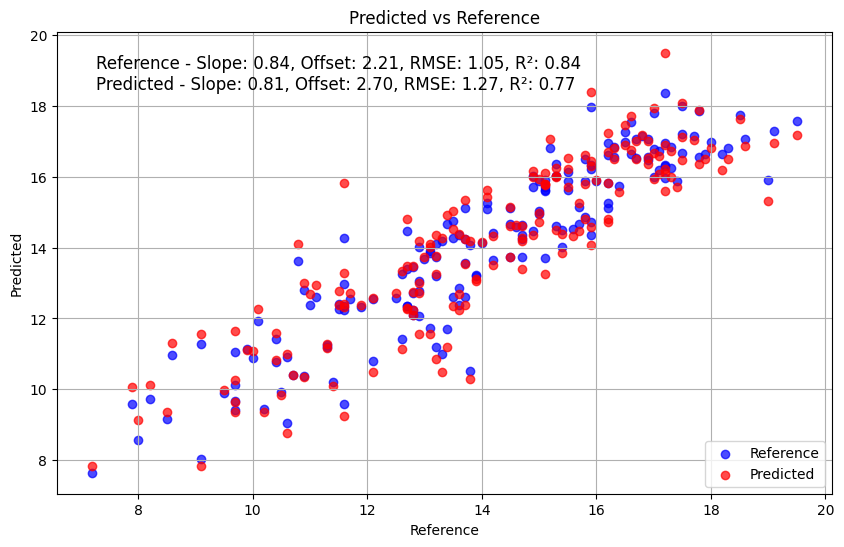

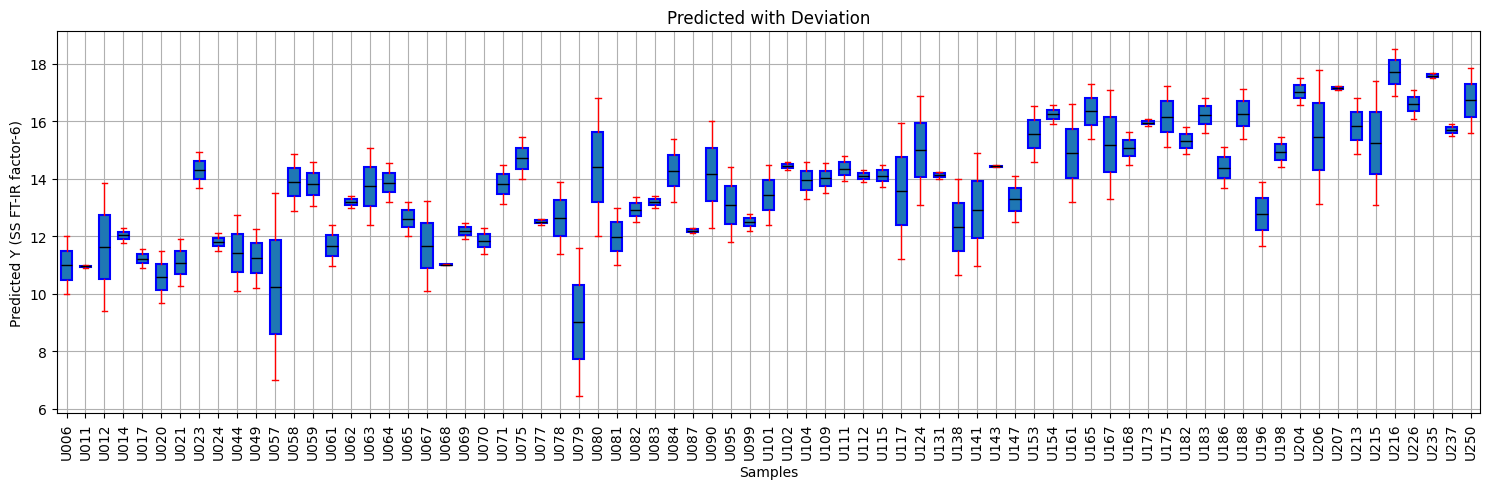

In [36]:
calibration, validation, prediction, Y_predict = build_model(df_msc_cal, df_msc_cal['SST'], df_msc_val, df_msc_val['SST'])


# Teste

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

def build_model2(num_files, file_names, variety, smp_size, rng_size, prediction_path):
    fields = [
        {'correlation', 'rpearson', 'rsquare', 'rmsec', 'sec', 'bias'},
        {'correlation', 'rpearson', 'rsquare', 'rmsecv', 'secv', 'bias'},
        {'correlation', 'rpearson', 'rsquare', 'rmsep', 'secp', 'bias'}
    ]
    
    calibration = {field: [[0] * len(field) for _ in range(num_files)] for field in fields[0]}
    validation = {field: [[0] * len(field) for _ in range(num_files)] for field in fields[1]}
    prediction = {field: [[0] * len(field) for _ in range(num_files)] for field in fields[2]}
    
    if prediction_path:
        pred_data = pd.read_excel(prediction_path)
        pred_abs_data = pred_data.iloc[1:, 3:]
        pred_qua_data = pred_data.iloc[1:, 2]
    
    cpred = [[] for _ in range(num_files)]
    cvpred = [[] for _ in range(num_files)]
    lv = np.zeros(num_files)
    
    for i in range(num_files):
        data = pd.read_excel(variety[i, 0])
        abs_data = data.iloc[1:, 3:]
        qua_data = data.iloc[1:, 2]
        
        abs_scaled, qua_scaled, _, m_qua = center_data(num_files, abs_data, qua_data, smp_size, rng_size)
        results, lv_num, model = train_model(i, abs_scaled, qua_scaled)
        
        if prediction_path:
            prediction = predict(model, pred_abs_data, pred_qua_data, prediction)
        
        lv[i] = lv_num
        cpred[i] = results.cpred
        cvpred[i] = results.cvpred
        
        calibration[fields[0][0]][i] = results.r2c[0, lv_num]
        calibration[fields[0][1]][i] = np.sqrt(calibration[fields[0][0]][i])
        calibration[fields[0][2]][i] = results.r2y[0, lv_num]
        calibration[fields[0][3]][i] = results.rmsec[0, lv_num]
        calibration[fields[0][4]][i] = cal_sec(calibration[fields[0][3]][i], smp_size)
        calibration[fields[0][5]][i] = results.cbias[0, lv_num]
        
        validation[fields[1][0]][i] = results.r2cv[0, lv_num]
        validation[fields[1][1]][i] = np.sqrt(validation[fields[1][0]][i])
        validation[fields[1][2]][i] = val_rsquare(qua_data, results.cumpress[0, lv_num], smp_size)
        validation[fields[1][3]][i] = results.rmsecv[0, lv_num]
        validation[fields[1][4]][i] = val_secv(results.cvpred, smp_size, validation[fields[1][4]][i], lv_num, m_qua, qua_data)
        validation[fields[1][5]][i] = results.cvbias[0, lv_num]
        
        export(calibration[i], validation[i], prediction[i], i, file_names, lv_num)
    
    return calibration, validation, lv, cpred, cvpred, m_qua

def cal_sec(rmsec, smp_size):
    num = (rmsec ** 2) * smp_size
    den = smp_size - 1
    return np.sqrt(num / den)

def val_rsquare(qua_data, cumpresslv, smp_size):
    med = np.mean(qua_data[:, 0])
    sum_sq = np.sum((qua_data[:, 0] - med) ** 2) / (smp_size - 2)
    return (sum_sq - (cumpresslv / smp_size)) / sum_sq

def val_secv(pred, smp_size, bias, lv_num, m_qua, qua_data):
    secv = 0
    max_lv = 0
    pred2 = np.zeros((smp_size, lv_num))

    for i in range(smp_size):
        for j in range(lv_num):
            pred2[i, j] = pred[i, :, j]

    for i in range(lv_num):
        pred2[:, i] = rescale2(pred2[:, i], m_qua)

    for i in range(smp_size):
        df = (pred2[i, lv_num - 1] - qua_data[i, 0] - bias) ** 2
        secv += df
    return np.sqrt(secv / (smp_size - 1))

def center_data(num_files, abs_data, qua_data, smp_size, rng_size):
    if abs_data.ndim > 2:
        mx = np.zeros((num_files, 1, rng_size))
        my = np.zeros((num_files, 1, 1))

        abs = np.zeros((num_files, smp_size, rng_size))
        qua = np.zeros((smp_size, num_files))

        for i in range(num_files):
            abs_data2 = abs_data[i, :, :]
            qua_data2 = qua_data[i, :, :]
            abs[i, :, :], mx[i, :, :] = mncn2(abs_data2)
            qua[:, i], my[i, :, :] = mncn2(qua_data2)
    else:
        mx = np.zeros((1, rng_size))
        my = np.zeros((1, 1))

        abs = np.zeros((smp_size, rng_size))
        qua = np.zeros((smp_size, 1))

        abs[:, :], mx[0, :] = mncn(abs_data)
        qua[:, 0], my[0, 0] = mncn(qua_data)

    return abs, qua, mx, my

def mncn2(x):
    m, _ = x.shape
    mx = np.mean(x, axis=0)
    mcx = x - mx[np.newaxis, :]
    return mcx, mx

def mncn(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data_scaled = (data - mean) / std
    return data_scaled, mean

def train_model(index, abs_scaled, qua_scaled):
    text9 = getappdata(0, 'text9')
    file_names = getappdata(0, 'file_names')
    pls_type = getappdata(0, 'pls_type')
    cv_type = getappdata(0, 'cv_type')
    max_lv = getappdata(0, 'max_lv')
    qua_text = getappdata(0, 'qua_text')

    text9.set_string(f"{qua_text}_{file_names[0, index]}")
    lvs = []
    k = 1

    options = {'display': 'off', 'plots': 'off'}

    results = cross_val_score(abs_scaled, qua_scaled, pls_type, cv_type, max_lv, **options)

    for j in range(max_lv - 1):
        aux = results.rmsecv[j] / results.rmsecv[j + 1]
        if aux > 1 and (aux - 1) * 100 >= 2:
            lvs.append(j + 2)
            k += 1

    if k == 1:
        lvs.append(1)
        k += 1
    lv_num = lvs[-1]
    _, ssq = pls(abs_scaled, qua_scaled, lvs[-1])

    for w in range(len(lvs) - 2):
        if ssq[lvs[w + 1], 3] < 1:
            lv_num = lvs[w]
            break

    options = {'display': 'off', 'plots': 'none'}
    model = pls(abs_scaled, qua_scaled, lv_num, **options)
    return results, lv_num, model

def print_results(calibration, validation):
    h_cal = calibration
    h_val = validation
    
    str1 = ['Correlation:', 'R2 (Pearson):', 'R-square:', 'RMSEC:', 'SEC:', 'Bias:']
    str2 = ['Correlation:', 'R2 (Pearson):', 'R-square:', 'RMSECV:', 'SECV:', 'Bias:']
    
    # Calibration
    print(f"{str1[0]} {calibration.correlation:.7f}")
    print(f"{str1[1]} {calibration.rpearson:.7f}")
    print(f"{str1[2]} {calibration.rsquare:.7f}")
    print(f"{str1[3]} {calibration.rmsec:.7f}")
    print(f"{str1[4]} {calibration.sec:.7f}")
    print(f"{str1[5]} {calibration.bias:.7f}")
    
    # Validation
    print(f"{str2[0]} {validation.correlation:.7f}")
    print(f"{str2[1]} {validation.rpearson:.7f}")
    print(f"{str2[2]} {validation.rsquare:.7f}")
    print(f"{str2[3]} {validation.rmsecv:.7f}")
    print(f"{str2[4]} {validation.secv:.7f}")
    print(f"{str2[5]} {validation.bias:.7f}")

def plot_points(pts, smp_size, current_file, color):
    lv = plt.get_current_fig_manager().canvas.figure.get_axes()[0].get_appdata('lv')
    axes1 = plt.get_current_fig_manager().canvas.figure.get_axes()[0]
    m_qua = plt.get_current_fig_manager().canvas.figure.get_axes()[0].get_appdata('m_qua')
    max_lv = plt.get_current_fig_manager().canvas.figure.get_axes()[0].get_appdata('max_lv')
    qua_data = plt.get_current_fig_manager().canvas.figure.get_axes()[0].get_appdata('qua_data')

    pts2 = np.zeros((smp_size, max_lv))
    for i in range(smp_size):
        for j in range(max_lv):
            pts2[i,j] = pts[i,:,j]

    pts3 = rescale2(pts2[:, lv[current_file, 0]], m_qua)

    for i in range(smp_size):
        axes1.plot(qua_data[i, 0], pts3[i, 0], f"{color}o", markerfacecolor=color, markersize=3)
    plt.show()

def rescale2(x, m):
    return (x - np.min(x)) / (np.max(x) - np.min(x)) * m

def rescale(x, mx, stdx):
    m, n = x.shape
    if len(mx.shape) == 1:
        mx = mx[:, None]
    if len(stdx.shape) == 1:
        stdx = stdx[:, None]
    
    if len(mx.shape) == len(stdx.shape) == 2:
        rx = (x * stdx[None, :]) + mx[None, :]
    else:
        rx = x + mx[None, :]
    
    return rx

def lv_number(max_lv, num_files, smp_size, rng_size, abs_scaled, qua_scaled, pls_type, cv_type, max_iter, m_qua):
    abs_scaled2 = np.zeros((smp_size, rng_size))
    lv_num = np.zeros((num_files, 1))
    text9 = getappdata(0, 'text9')
    file_names = getappdata(0, 'file_names')
    time = np.zeros((1, num_files))

    for i in range(num_files):
        set(text9, 'string', file_names[0, i])
        lvs = []
        k = 1
        abs_scaled2[:, :] = abs_scaled[i, :, :]
        start_time = time.time()
        results = cross_val_score(PLSRegression(n_components=max_lv), abs_scaled2, qua_scaled[:, i], cv=cv_type)

        for j in range(max_lv - 1):
            aux = results.rmsecv[j] / results.rmsecv[j + 1]
            if aux > 1 and (aux - 1) * 100 >= 2:
                lvs.append(j + 1)
                k += 1

        pls_model = PLSRegression(n_components=k - 1)
        pls_model.fit(abs_scaled2, qua_scaled[:, i])
        b, ssq = pls_model.coef_, pls_model.score_
        for w in range(k - 2):
            if ssq[lvs[w + 1], 2] < 1 and ssq[lvs[w + 1], 4] < 0.9:
                lv_num[i, 0] = lvs[w]
                break

        end_time = time.time()
        time[0, i] = end_time - start_time

        setappdata(0, 'results', results)
        setappdata(0, 'time', time)
    return lv_num

def predict(model, pred_abs, pred_qua, prediction):
    t, _ = pred_qua.shape
    pred_abs_scaled, _ = mncn2(pred_abs)
    pred_qua_scaled, _ = mncn2(pred_qua)

    options = {'display': 'off', 'plots': 'none'}
    pred = pls(pred_abs_scaled, pred_qua_scaled, model, options)

    prediction['rpearson'] = pred['detail']['r2p']
    prediction['correlation'] = np.sqrt(prediction['rpearson'])
    prediction['rsquare'] = rsquare(pred_qua, pred['ssqresiduals'][1][1], t)
    prediction['rmsep'] = pred['detail']['rmsep']
    prediction['secp'] = secv(pred['pred'][1], t, pred['detail']['predbias'], pred_qua)
    prediction['bias'] = pred['detail']['predbias']
    return prediction

def rsquare(qua_data, cumpress, smp_size):
    med = np.mean(qua_data[:, 0])
    sum_sq = 0
    for i in range(smp_size):
        qua_data[i, 0] = (qua_data[i, 0] - med) ** 2
        sum_sq += qua_data[i, 0]
    sum_sq = sum_sq / (smp_size - 2)
    r = (sum_sq - (cumpress / smp_size)) / sum_sq
    return r

def secv(pred, smp_size, bias, qua_data):
    s = 0
    for i in range(smp_size):
        df = (pred[i, 0] - qua_data[i, 0] - bias) ** 2
        s += df
    s = np.sqrt(s / (smp_size - 1))
    return s

In [53]:
num_files = 1  # Defina o número de arquivos ou amostras
file_names = ['MSC']  # Lista de nomes de arquivos
variety = [['Cotton']]  # Dados de variedade (verifique o formato correto)
smp_size = 175  # Tamanho da amostra
rng_size = 2151  # Tamanho do range
file_path_msc_val # Caminho para o arquivo de predição, se aplicável

calibration, validation, lv, cpred, cvpred, m_qua = build_model2(num_files, file_names, variety, smp_size, rng_size, file_path_msc_val)

# Exemplo de como imprimir resultados
print_results(calibration, validation)

TypeError: list indices must be integers or slices, not tuple

In [45]:
def center_data(abs_data, qua_data):
    smp_size = abs_data.shape[0]
    rng_size = abs_data.shape[1]

    mx = np.zeros(rng_size)
    my = np.zeros(1)

    abs_centered = np.zeros((smp_size, rng_size))
    qua_centered = np.zeros((smp_size, 1))

    abs_centered[:, :], mx[:] = mncn(abs_data)
    qua_centered[:, 0], my[0] = mncn(qua_data)

    return abs_centered, qua_centered, mx, my

# Função auxiliar para centralização e cálculo da média utilizada no scaling
def mncn(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data_scaled = (data - mean) / std
    return data_scaled, mean

def train_model(abs_scaled, qua_scaled):
    # Definindo as opções de cross-validation
    cv_method = LeaveOneOut()
    
    # Inicializa variáveis e estruturas de dados
    lvs = []
    k = 1
    max_lv = 10
    # Realiza a validação cruzada para determinar o melhor número de LVs
    rmsecv = cross_val_score(PLSRegression(n_components=max_lv), abs_scaled, qua_scaled, cv=cv_method, scoring='neg_mean_squared_error')
    rmsecv = np.sqrt(-rmsecv)

    for j in range(max_lv - 1):
        aux = rmsecv[j] / rmsecv[j + 1]
        if aux > 1:
            if ((aux - 1) * 100 >= 2):
                lvs.append(j + 1)
                k += 1

    if k == 1:
        lvs.append(1)

    lv_num = lvs[-1]

    # Treina o modelo PLS com o número ótimo de componentes latentes
    model = PLSRegression(n_components=lv_num)
    model.fit(abs_scaled, qua_scaled)

    # Retorna os resultados, número de LVs e o modelo treinado
    results = {
        'rmsecv': rmsecv, 
    }

    return results, lv_num, model

def predict(model, pred_abs, pred_qua):
    t = pred_qua.shape

    # Normalização dos dados preditivos
    pred_abs_scaled = mncn(pred_abs)
    pred_qua_scaled = mncn(pred_qua)

    # Treinamento do modelo PLSR
    model_pls = PLSRegression(n_components=model.n_components)
    model_pls.coef_ = model.coef_
    model_pls.x_scores_ = model.x_scores_
    model.abs_mean_ = np.mean(pred_abs_scaled[0], axis=0)
    model_pls.x_std_ = model.x_std_
    model.qua_mean_ = np.mean(pred_qua_scaled[0])
    model_pls.y_std_ = model.y_std_

    # Predição dos dados
    pred = model_pls.predict(pred_abs_scaled)

    # Cálculo das métricas de predição
    prediction = {}
    prediction['rpearson'] = model.score(pred_abs_scaled, pred_qua_scaled)
    prediction['correlation'] = np.sqrt(prediction['rpearson'])
    prediction['rsquare'] = rsquare(pred_qua, model.residuals_, t)
    prediction['rmsep'] = np.sqrt(np.mean((pred_qua_scaled - pred) ** 2))
    prediction['secp'] = secv(pred, t, model.y_mean_, pred_qua_scaled)
    prediction['bias'] = model.y_mean_

    return prediction

def rescale2(x, mx, stdx=None):
    m, n = x.shape
    if stdx is not None:
        rx = (x * stdx[np.newaxis, :]) + mx[np.newaxis, :]
    else:
        rx = x + mx[np.newaxis, :]
    return rx

def cal_sec(rmsec, smp_size):
    num = (rmsec ** 2) * smp_size
    den = smp_size - 1
    sec = np.sqrt(num / den)
    return sec

def val_rsquare(qua_data, cumpresslv, smp_size):
    med = np.mean(qua_data[:, 0])
    suma = 0

    for i in range(smp_size):
        qua_data[i, 0] = (qua_data[i, 0] - med) ** 2
        suma = suma + qua_data[i, 0]

    suma = suma / (smp_size - 2)
    rsquare = (suma - (cumpresslv / smp_size)) / suma
    return rsquare

def val_secv(pred, smp_size, bias, lv_num, m_qua, qua_data):
    secv = 0
    max_lv = 10  # Exemplo de valor de max_lv, substitua conforme necessário
    pred2 = np.zeros((smp_size, lv_num))

    for i in range(smp_size):
        for j in range(lv_num):
            pred2[i, j] = pred[i, j]

    for i in range(lv_num):
        pred2[:, i] = rescale2(pred2[:, i], m_qua)  # Implemente rescale2 conforme necessário

    for i in range(smp_size):
        df = (pred2[i, lv_num - 1] - qua_data[i, 0] - bias) ** 2
        secv = secv + df

    secv = np.sqrt(secv / (smp_size - 1))
    return secv

def optimal_lv(x_block, y_block):
    lv_range = range(1, min(x_block.shape[1], y_block.shape[1]) + 1)  # Faixa de números de LVs

    rmsecv = np.zeros(len(lv_range))

    for i, lv in enumerate(lv_range):
        pls = PLSRegression(n_components=lv)
        y_pred = cross_val_predict(pls, x_block, y_block, cv=x_block.shape[0])  # Leave-one-out CV
        rmsecv[i] = np.sqrt(mean_squared_error(y_block, y_pred))

    lvs = []
    k = 0

    for j in range(len(rmsecv) - 1):
        aux = rmsecv[j] / rmsecv[j + 1]
        if aux > 1:
            if ((aux - 1) * 100 >= 2):
                lvs.append(j + 2)
                k += 1

    if k == 0:
        lvs.append(1)
        k += 1

    lv_num = lvs[-1]
    pls = PLSRegression(n_components=lv_num)
    pls.fit(x_block, y_block)
    ssq = pls.x_scores_

    for w in range(k - 1):
        if ssq[lvs[w], 3] < 1:
            lv_num = lvs[w]
            break

    return lv_num


def main(X, Y, X_pred, Y_pred):
    field1 = ['correlation', 'rpearson', 'rsquare', 'rmsec', 'sec', 'bias']
    field2 = ['correlation', 'rpearson', 'rsquare', 'rmsecv', 'secv', 'bias']
    field3 = ['correlation', 'rpearson', 'rsquare', 'rmsep', 'secp', 'bias']
    num_files = 1
    smp_size = X.shape[0]
    cells = [[0] * len(field1) for _ in range(num_files)]

    calibration = {field1[i]: cells for i in range(len(field1))}
    validation = {field2[i]: cells for i in range(len(field2))}
    prediction = {field3[i]: cells for i in range(len(field3))}
    
    pred_abs_data = X_pred  # Dados de onda
    pred_qua_data = Y_pred   # Dados de qualidade

    # Convertendo para numpy arrays, se necessário
    pred_abs_data = pred_abs_data.to_numpy()
    pred_qua_data = pred_qua_data.to_numpy()

    # Exemplo de acesso aos dados
    #print(pred_abs_data)
    #print(pred_qua_data)
    
    cpred = []  
    cvpred = []  
    lv = np.zeros(num_files)  
    
    abs_data = X.to_numpy()  # Exemplo de dados de abs_data
    qua_data = Y.to_numpy()   # Exemplo de dados de qua_data
    
    abs_scaled, qua_scaled, mx, my = center_data(abs_data, qua_data)
    results, lv_num, model = train_model(abs_scaled, qua_scaled)
    
    # Substitua pelo caminho real do seu arquivo de predição
    
    prediction = predict(model, pred_abs_data, pred_qua_data)
    
    lv = lv_num
    cpred = results.get('cpred', None)
    cvpred = results.get('cvpred', None)
    
    calibration['rpearson'] = results.get('r2c', [])[0, lv_num]
    calibration['correlation'] = np.sqrt(calibration['rpearson'])
    calibration['rsquare'] = results.get('r2y', [])[0, lv_num]
    calibration['rmsec'] = results.get('rmsec', [])[0, lv_num]
    calibration['sec'] = cal_sec(calibration['rmsec'], smp_size)  # Implemente cal_sec conforme necessário
    calibration['bias'] = results.get('cbias', [])[0, lv_num]
    
    validation['rpearson'] = results.get('r2cv', [])[0, lv_num]
    validation['correlation'] = np.sqrt(validation['rpearson'])
    validation['rsquare'] = val_rsquare(qua_data, results.get('cumpress', [])[0, lv_num], smp_size)  # Implemente val_rsquare conforme necessário
    validation['rmsecv'] = results.get('rmsecv', [])[0, lv_num]
    validation['bias'] = results.get('cvbias', [])[0, lv_num]
    validation['secv'] = val_secv(results.get('cvpred', []), smp_size, validation['bias'], lv_num, None, qua_data)  # Implemente val_secv conforme necessário


In [46]:
main(df_msc_cal.iloc[:,6:], df_msc_cal['SST'], df_msc_val.iloc[:,6:], df_msc_val['SST'])

AttributeError: 'PLSRegression' object has no attribute 'x_std_'

# Teste

In [26]:
from sklearn.metrics import explained_variance_score

def explained_variance(y_true, y_pred):
    return explained_variance_score(y_true, y_pred)

def variance(pls, X, y_true):
    loo = LeaveOneOut()
    explained_variances = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_true[train_index], y_true[test_index]
        
        # Calibração do modelo nos dados de treinamento
        pls.fit(X_train, y_train)
        y_train_pred = pls.predict(X_train)
        explained_variances.append(explained_variance(y_train, y_train_pred))

    return explained_variances
           
def determine_optimal_components(X, Y, components=10):
    X_centered = X - np.mean(X, axis=0)
    Y_centered = Y - np.mean(Y, axis=0)
    factors = np.arange(1, components+1)
    explained_variance_train = []
    explained_variance_test = []
    
    
    for i in factors:
        pls = PLSRegression(n_components=i, max_iter=100)
        pls.fit(X_centered, Y_centered)
        pls.score(X_centered, Y_centered)
        explained_variance_train.append(r2_score(Y_centered, pls.predict(X_centered)))
        
        loo = LeaveOneOut()
        y_cv = cross_val_predict(pls, X_centered, Y_centered, cv=loo)  # LOO Cross-validation
        explained_variance_test.append(r2_score(Y_centered, y_cv))
    
       
    print("Mean explained variance (train):", explained_variance_train)
    print("Mean explained variance (test):", explained_variance_test)
    
    


# Avaliação do modelo
def evaluate_model(pls, X_test, Y_test):
    Y_pred = pls.predict(X_test)
    r2 = r2_score(Y_test, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    bias = np.mean(Y_pred - Y_test)
    return r2, rmse, bias, Y_pred

# Predição em novos dados
def predict_new_data(pls, X_new, Y_reference):
    Y_pred = pls.predict(X_new)
    diff = Y_pred - Y_reference
    results_df = pd.DataFrame({'Predicted': Y_pred.flatten(), 'Reference': Y_reference.flatten(), 'Difference': diff.flatten()})
    return results_df

def plot_variances(explained_variances, residual_variances):
    components = range(1, len(explained_variances) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(components, explained_variances, marker='o', linestyle='-', color='b', label='Explained Variance')
    plt.plot(components, residual_variances, marker='o', linestyle='-', color='r', label='Residual Variance')
    plt.title('Explained and Residual Variances vs Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')
    plt.xticks(components)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Função para plotar Predicted vs. Reference com as métricas
def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, title="Predicted vs Reference"):
    Y_true_flat = Y_true.flatten()
    Y_pred_flat = Y_pred.flatten()
    
    slope_pred, offset_pred = np.polyfit(Y_true_flat, Y_pred_flat, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true_flat, Y_pred_flat))
    r2_pred = r2_score(Y_true_flat, Y_pred_flat)
    
    slope_opt, offset_opt = np.polyfit(Y_true_flat, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true_flat, Y_opt))
    r2_opt = r2_score(Y_true_flat, Y_opt)
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true_flat, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)
    
    # Scatter plot for predicted values
    plt.scatter(Y_true_flat, Y_pred_flat, color='red', label='Predicted', marker='o', alpha=0.7)
    
    # Plotting regression lines
    #plt.plot(Y_true_flat, slope_opt * Y_true_flat + offset_opt, color='blue', linestyle='-', label='Reference Line')
    #plt.plot(Y_true_flat, slope_pred * Y_true_flat + offset_pred, color='red', linestyle='-', label='Predicted Line')
    
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.legend(loc='lower right')
    plt.show()

# Função para calcular as métricas de predição
def calculate_metrics(Y_true, Y_pred):
    Y_true_flat = Y_true.flatten()
    Y_pred_flat = Y_pred.flatten()
    slope, offset = np.polyfit(Y_true_flat, Y_pred_flat, 1)
    rmse = np.sqrt(mean_squared_error(Y_true_flat, Y_pred_flat))
    r2 = r2_score(Y_true_flat, Y_pred_flat)
    return {"Slope": slope, "Offset": offset, "RMSE": rmse, "R²": r2}

In [27]:
results = determine_optimal_components(df_msc_cal.iloc[:,6:].values, df_msc_cal['SST'].values.reshape(-1, 1), 10)

print("Número ótimo de componentes:", results)


Mean explained variance (train): [0.5969765884327838, 0.6260491212842967, 0.7107400823907399, 0.7269256458451415, 0.7424864806523239, 0.7788993488403027, 0.8002597298051033, 0.8259628791834941, 0.8434751255020471, 0.8625502844169882]
Mean explained variance (test): [0.5765420328556601, 0.6007018600761844, 0.664476134354046, 0.6868454003621965, 0.7025597162186696, 0.7254853315619423, 0.7350851094791533, 0.7479971675791086, 0.770042320069034, 0.7537151917549334]
Número ótimo de componentes: None


In [151]:

def plot_variances(explained_variances, residual_variances):
    components = range(1, len(explained_variances) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(components, explained_variances, marker='o', linestyle='-', color='b', label='Explained Variance')
    plt.plot(components, residual_variances, marker='o', linestyle='-', color='r', label='Residual Variance')
    plt.title('Explained and Residual Variances vs Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')
    plt.xticks(components)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Função para plotar Predicted vs. Reference com as métricas
def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, title="Predicted vs Reference"):
    Y_true_flat = Y_true.flatten()
    Y_pred_flat = Y_pred.flatten()
    
    slope_pred, offset_pred = np.polyfit(Y_true_flat, Y_pred_flat, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true_flat, Y_pred_flat))
    r2_pred = r2_score(Y_true_flat, Y_pred_flat)
    
    slope_opt, offset_opt = np.polyfit(Y_true_flat, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true_flat, Y_opt))
    r2_opt = r2_score(Y_true_flat, Y_opt)
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true_flat, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)
    
    # Scatter plot for predicted values
    plt.scatter(Y_true_flat, Y_pred_flat, color='red', label='Predicted', marker='o', alpha=0.7)
    
    # Plotting regression lines
    #plt.plot(Y_true_flat, slope_opt * Y_true_flat + offset_opt, color='blue', linestyle='-', label='Reference Line')
    #plt.plot(Y_true_flat, slope_pred * Y_true_flat + offset_pred, color='red', linestyle='-', label='Predicted Line')
    
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.legend(loc='lower right')
    plt.show()

# Função para calcular as métricas de predição
def calculate_metrics(Y_true, Y_pred):
    Y_true_flat = Y_true.flatten()
    Y_pred_flat = Y_pred.flatten()
    slope, offset = np.polyfit(Y_true_flat, Y_pred_flat, 1)
    rmse = np.sqrt(mean_squared_error(Y_true_flat, Y_pred_flat))
    r2 = r2_score(Y_true_flat, Y_pred_flat)
    return {"Slope": slope, "Offset": offset, "RMSE": rmse, "R²": r2}



# PLSR - MSC

Explained Variances of Components: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
R² Scores of Components: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Residual Variances of Components: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


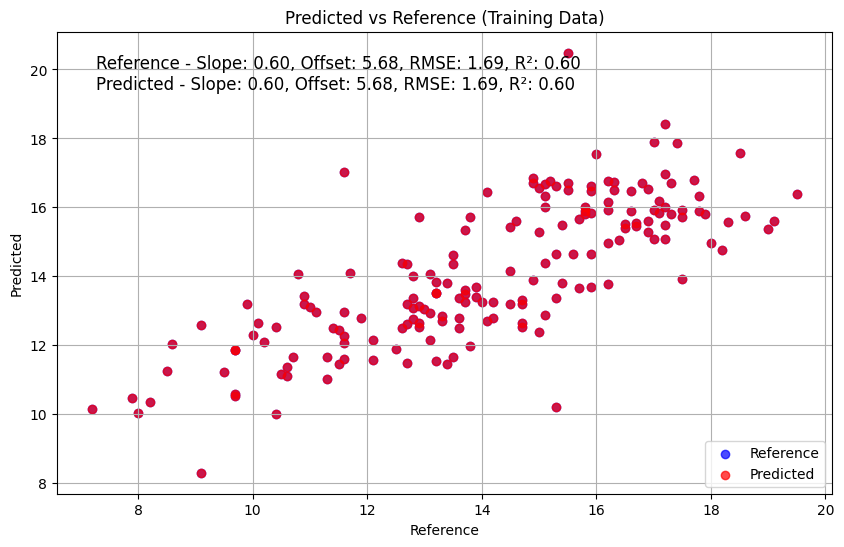

In [150]:
X = df_msc_cal.iloc[:,6:].values  # Exemplo de dados espectroscópicos
Y = df_msc_cal['SST'].values  # Exemplo de atributo de qualidade

# Centralizar os dados
X_centered = mean_center_data(X)

components = int(15*0.7)

# Encontrar o número ótimo de componentes
optimal_components, explained_variances, residual_variances = determine_optimal_components(X_centered, Y, components)

# Ajustar o modelo PLSR com o número ótimo de componentes
pls_model = PLSRegression(n_components=optimal_components)
pls_model.fit(mean_center_data(X), Y)

Y_pred_optimal = predict_with_optimal_components(pls_model, mean_center_data(X))

# Ajustar o modelo PLSR com o número ótimo de componentes
pls = PLSRegression(n_components=optimal_components)
pls.fit(X_centered, Y)
Y_train_pred = pls.predict(X_centered)
plot_pred_vs_ref(Y, Y_train_pred, Y_pred_optimal, title="Predicted vs Reference (Training Data)")
df = pd.DataFrame({
    "Prediction Calibration": Y_pred_optimal.flatten(),
    "Prediction Validation": Y_train_pred.flatten(),
    "Reference": Y.flatten(),
    "Difference": (Y - Y_train_pred).flatten()
})
df.insert(0, 'Amostra', df_msc_cal[df_msc_cal.columns[0]])
df

# Calcular as métricas de predição
metrics = calculate_metrics(Y, Y_train_pred)

# Plotar Predicted vs. Reference

# Supondo novos dados para predição
X_new = df_msc_val.iloc[:,6:].values  # Novos dados espectroscópicos
Y_new = df_msc_val['SST'].values  # Atributo de qualidade real
X_new_centered = mean_center_data(X_new)


# Aplicar o modelo nos novos dados
Y_new_pred = pls.predict(X_new_centered)

# Calcular as métricas de predição nos novos dados
metrics_new = calculate_metrics(Y_new, Y_new_pred)

# Plotar Predicted vs. Reference para os novos dados

# Gerar um DataFrame com a predição, referência e diferença# Certifique-se de que os arrays têm o mesmo comprimento
result_df = pd.DataFrame({
    "Prediction": Y_new_pred.flatten(),
    "Reference": Y_new.flatten(),
    "Difference": (Y_new - Y_new_pred).flatten()
})
result_df.insert(0, 'Amostra', df_msc_val[df_msc_val.columns[0]])
# Exibir o DataFrame
#result_df


In [147]:
df

,Amostra,Prediction Calibration,Prediction Validation,Reference,Difference
0,U001,12.060823,12.060823,11.6,-0.460823
1,U002,11.675582,11.675582,11.3,-0.375582
2,U003,12.507966,12.507966,11.4,-1.107966
3,U004,12.285341,12.285341,11.6,-0.685341
4,U005,11.036840,11.036840,11.3,0.263160
...,...,...,...,...,...
170,U245,16.774263,16.774263,15.2,-1.574263
171,U246,16.009424,16.009424,17.2,1.190576
172,U247,16.470296,16.470296,15.9,-0.570296
173,U248,15.902994,15.902994,16.6,0.697006


In [148]:
result_df

,Amostra,Prediction,Reference,Difference
0,U006,12.201399,12.0,-0.201399
1,U011,12.123887,11.0,-1.123887
2,U012,12.439713,9.4,-3.039713
3,U014,13.159484,12.3,-0.859484
4,U017,12.451146,10.9,-1.551146
...,...,...,...,...
70,U216,15.764089,16.9,1.135911
71,U226,14.940445,17.1,2.159555
72,U235,17.867858,17.5,-0.367858
73,U237,14.673677,15.9,1.226323
